In [2]:
import string
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from utils import grad_finite_diff
from oracles import BinaryLogistic
from optimization import GDClassifier, SGDClassifier
import time
from  tqdm import tqdm
import matplotlib.pyplot as plt

# 1

In [3]:
train = pd.read_csv("toxic_train.csv")

In [3]:
train

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False
...,...,...,...
52056,159494,"""\n\n our previous conversation \n\nyou fuckin...",True
52057,159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,True
52058,159541,Your absurd edits \n\nYour absurd edits on gre...,True
52059,159546,"""\n\nHey listen don't you ever!!!! Delete my e...",True


In [4]:
def preprocess1(texts):
    return texts.str.lower().str.strip().str.replace(r'[^a-zA-Z0-9]', ' ', regex=True)

In [18]:
preprocessed = preprocess1(train.comment_text)

In [24]:
preprocessed

,comment_text
0,explanation why the edits made under my userna...
1,d aww he matches this background colour i m s...
2,hey man i m really not trying to edit war it...
3,more i can t make any real suggestions on im...
4,you sir are my hero any chance you remember...
...,...
52056,our previous conversation you fucking sh...
52057,you are a mischievious pubic hair
52058,your absurd edits your absurd edits on great...
52059,hey listen don t you ever delete my edi...


# 2

In [6]:
vectorizer = CountVectorizer(min_df=0.001, max_df=0.85)
vect_data = vectorizer.fit_transform(preprocessed)

In [8]:
vect_data

<52061x3736 sparse matrix of type '<class 'numpy.int64'>'
	with 1795438 stored elements in Compressed Sparse Row format>

# 3

In [14]:
bl = BinaryLogistic(l2_coef=1)
X = vect_data
y = np.array(train.is_toxic.astype(int))
w = np.random.rand(vect_data.shape[0])
bl.func(X, y ,w)
bl.grad(X,y,w)
print(np.sum(bl.grad(X,y,w) - grad_finite_diff(X,y,w, l2_coef=1, eps=1e-8))/(len(y)))

ValueError: dimension mismatch

In [10]:
grad_time= []
grad_diff_time = []
bl = BinaryLogistic(l2_coef=1)
for r in range(100, 2000 + 1, 100):
  w = np.random.rand(r)
  X = vect_data[:100, :r]
  y = np.array(train.is_toxic[:100].astype(int))
  print(w.shape, y.shape, X.shape)

  s = time.time()
  bl.grad(X,y,w)
  grad_time.append(time.time() - s)

  s = time.time()
  grad_finite_diff(X,y,w, l2_coef=1, eps=1e-8)
  grad_diff_time.append(time.time() - s)


(100,) (100,) (100, 100)
(200,) (100,) (100, 200)
(300,) (100,) (100, 300)
(400,) (100,) (100, 400)
(500,) (100,) (100, 500)
(600,) (100,) (100, 600)
(700,) (100,) (100, 700)
(800,) (100,) (100, 800)
(900,) (100,) (100, 900)
(1000,) (100,) (100, 1000)
(1100,) (100,) (100, 1100)
(1200,) (100,) (100, 1200)
(1300,) (100,) (100, 1300)
(1400,) (100,) (100, 1400)
(1500,) (100,) (100, 1500)
(1600,) (100,) (100, 1600)
(1700,) (100,) (100, 1700)
(1800,) (100,) (100, 1800)
(1900,) (100,) (100, 1900)
(2000,) (100,) (100, 2000)


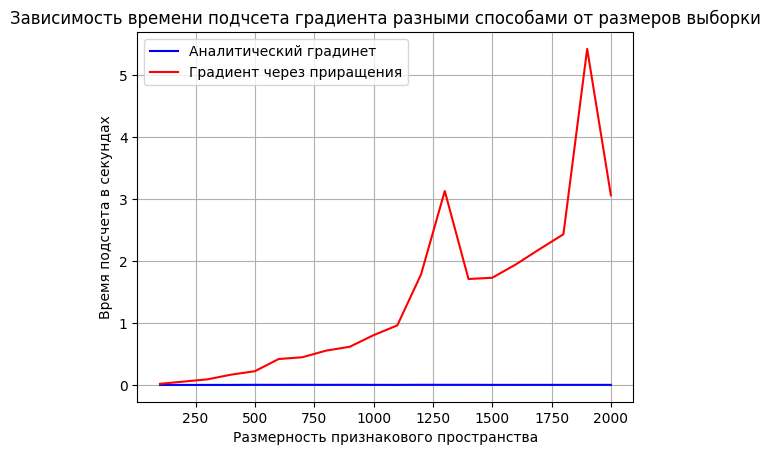

In [11]:
plt.title("")
plt.plot(range(100, 2000 + 1, 100), grad_time, color="b", label="Аналитический градинет")
plt.plot(range(100, 2000 + 1, 100), grad_diff_time, color="r", label="Градиент через приращения")
plt.grid()
plt.legend()
plt.title("Зависимость времени подчсета градиента разными способами от размеров выборки")
plt.xlabel("Размерность признакового пространства")
plt.ylabel("Время подсчета в секундах")
plt.show()

# 4


In [47]:
params = np.logspace(-2,-1,base=10,num = 4)
X = vect_data[:1000]
y = np.where(train.is_toxic[:1000].astype(int) == 0, -1, 0)
w = np.zeros(X.shape[1])
results = []
for alpha in tqdm(params):
    c = GDClassifier(loss_function="binary",tolerance=1e-6,max_iter = 1000, step_alpha=alpha)
    results.append(c.fit(X, y, w_0=w, trace=True))


100%|██████████| 4/4 [09:48<00:00, 147.04s/it]


In [52]:
params

array([0.1       , 0.21544347, 0.46415888, 1.        ])

Text(0, 0.5, 'Значение функии потерь')

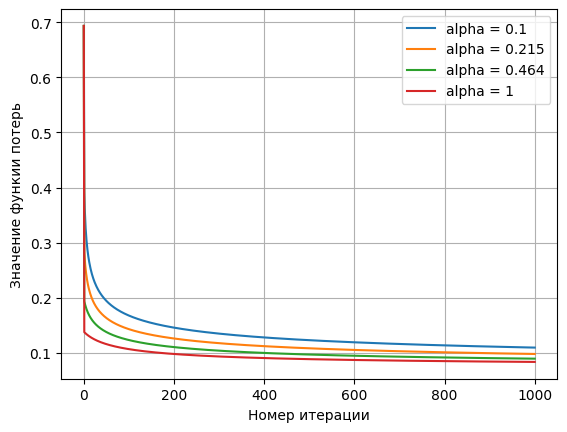

In [53]:
y = results[0]["func"]
x = np.arange(len(results[0]["func"]))
plt.plot(x,y, label="alpha = 0.1")

y = results[1]["func"]
x = np.arange(len(results[1]["func"]))
plt.plot(x,y, label="alpha = 0.215")

y = results[2]["func"]
x = np.arange(len(results[2]["func"]))
plt.plot(x,y, label="alpha = 0.464")

y = results[3]["func"]
x = np.arange(len(results[3]["func"]))
plt.plot(x,y, label="alpha = 1")

# y = results[4]["func"]
# x = np.arange(len(results[4]["func"]))
# plt.plot(x,y, label="alpha = 1e+1")

# y = results[5]["func"]
# x = np.arange(len(results[5]["func"]))
# plt.plot(x,y, label="alpha = 1e+2")

# y = results[6]["func"]
# x = np.arange(len(results[6]["func"]))
# plt.plot(x,y, label="alpha = 1e+3")





plt.legend()
plt.grid()

plt.xlabel("Номер итерации")
plt.ylabel("Значение функии потерь")

In [50]:
params = np.logspace(-1,0,base=10,num = 4)
X = vect_data[:1000]
y = np.where(train.is_toxic[:1000].astype(int) == 0, -1, 0)
w = np.zeros(X.shape[1])
results = []
for alpha in tqdm(params):
    c = GDClassifier(loss_function="binary",tolerance=1e-6,max_iter = 1000, step_alpha=alpha)
    results.append(c.fit(X, y, w_0=w, trace=True))

100%|██████████| 4/4 [09:33<00:00, 143.31s/it]


[0.108, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891]
[0.108, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891]
[0.108, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891]
[0.108, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891]


Text(0, 0.5, 'Accuracy на тренировчной выборке')

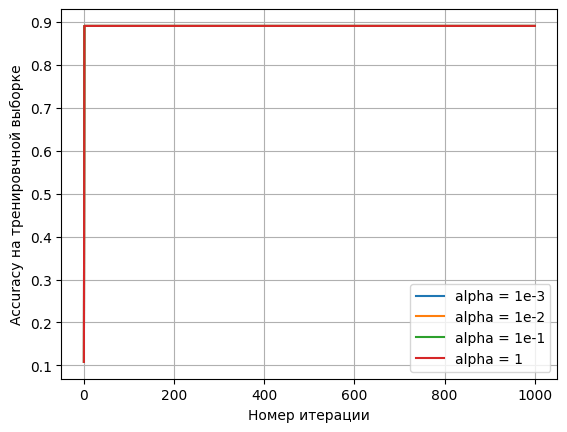

In [54]:
y = results[0]["accuracy"]
x = np.arange(len(results[0]["accuracy"]))
plt.plot(x,y, label="alpha = 1e-3")
print(y[:10])

y = results[1]["accuracy"]
x = np.arange(len(results[1]["accuracy"]))
plt.plot(x,y, label="alpha = 1e-2")
print(y[:10])

y = results[2]["accuracy"]
x = np.arange(len(results[2]["accuracy"]))
plt.plot(x,y, label="alpha = 1e-1")
print(y[:10])

y = results[3]["accuracy"]
x = np.arange(len(results[3]["accuracy"]))
plt.plot(x,y, label="alpha = 1")
print(y[:10])


plt.legend()
plt.grid()
plt.xlabel("Номер итерации")
plt.ylabel("Accuracy на тренировчной выборке")

In [38]:
params = np.logspace(-3,-2,base=10,num = 3)
X = vect_data[:1000]
y = np.where(train.is_toxic[:1000].astype(int) == 0, -1, 0)
w = np.zeros(X.shape[1])
results = []
for beta in tqdm(params):
    c = GDClassifier(loss_function="binary",  max_iter = 1000, step_beta=beta)
    results.append(c.fit(X, y, w_0=w, trace=True))

100%|██████████| 3/3 [02:21<00:00, 47.07s/it]


[0.6931471805599454, 0.13781957862873695, 0.13702629162149157, 0.1362613604442908, 0.13552299116029473, 0.1348095832329012, 0.13411968597209048, 0.13345197440167295, 0.13280523257351592, 0.13217834070174364, 0.1315702646645131, 0.13098004716274556, 0.13040680013091663, 0.129849698141021, 0.12930797261951205, 0.12878090674387896, 0.12826783091581584, 0.12776811872883626, 0.12728118336336616, 0.12680647435381004]
[0.6931471805599454, 0.13781957862873695, 0.1370311807365633, 0.13627354101472752, 0.1355438399101796, 0.1348399241846205, 0.13416000614995133, 0.1335025405639558, 0.13286616123440528, 0.13224964309855136, 0.1316518770524389, 0.13107185195193666, 0.1305086410265264, 0.12996139120695466, 0.12942931448830422, 0.1289116807803648, 0.12840781188483064, 0.1279170763514947, 0.1274388850365116, 0.12697268723232066]
[0.6931471805599454, 0.13781957862873695, 0.13707845876511307, 0.13639009952067804, 0.1357418779859849, 0.13512656631131023, 0.13453937227962187, 0.13397683049398723, 0.13343

Text(0, 0.5, 'Значение функии потерь')

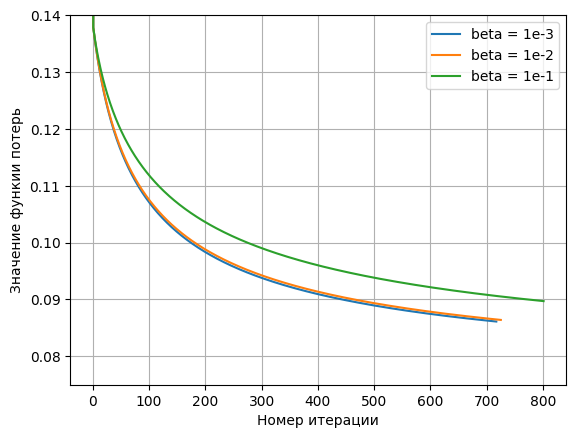

In [42]:
y = results[0]["func"]
x = np.arange(len(results[0]["func"]))
plt.plot(x,y, label="beta = 1e-3")
print(y[:20])

y = results[1]["func"]
x = np.arange(len(results[1]["func"]))
plt.plot(x,y, label="beta = 1e-2")
print(y[:20])

y = results[2]["func"]
x = np.arange(len(results[2]["func"]))
plt.plot(x,y, label="beta = 1e-1")
print(y[:20])
# y = results[3]["func"]
# x = np.arange(len(results[3]["func"]))
# plt.plot(x,y, label="beta = 1")
# print(y[:20])
# y = results[4]["func"]
# x = np.arange(len(results[4]["func"]))
# plt.plot(x,y, label="beta = 1e+1")
# print(y[:20])
# y = results[5]["func"]
# x = np.arange(len(results[5]["func"]))
# plt.plot(x,y, label="beta = 1e+2")
# print(y[:20])
# y = results[6]["func"]
# x = np.arange(len(results[6]["func"]))
# plt.plot(x,y, label="beta = 1e+3")
# print(y[:20])

plt.legend()
plt.grid()
plt.ylim(0.075,0.14)
plt.xlabel("Номер итерации")
plt.ylabel("Значение функии потерь")

[0.108, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891]
[0.108, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891]
[0.108, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891, 0.891]


Text(0, 0.5, 'Accuracy на тренировчной выборке')

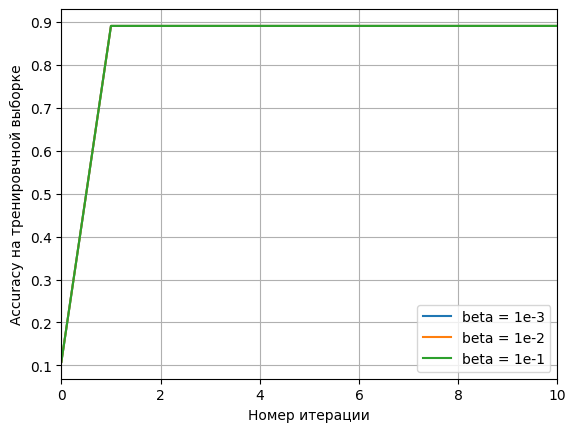

In [43]:
y = results[0]["accuracy"]
x = np.arange(len(results[0]["accuracy"]))
plt.plot(x,y, label="beta = 1e-3")
print(y[:20])

y = results[1]["accuracy"]
x = np.arange(len(results[1]["accuracy"]))
plt.plot(x,y, label="beta = 1e-2")
print(y[:20])

y = results[2]["accuracy"]
x = np.arange(len(results[2]["accuracy"]))
plt.plot(x,y, label="beta = 1e-1")
print(y[:20])


plt.legend()
plt.grid()
plt.xlim(0,10)
plt.xlabel("Номер итерации")
plt.ylabel("Accuracy на тренировчной выборке")

In [56]:
c = GDClassifier(step_alpha = 0.1, step_beta = 0.01, max_iter = 100)
y = np.where(train.is_toxic.astype(int) == 0, -1, 0)
w = np.zeros(vect_data.shape[1])
c.fit(vect_data, y, w_0=w)
c.accuracy(vect_data, y)

0.688173488791994

# 5

In [15]:
params = np.logspace(-2,0,base=10,num = 4)
X = vect_data
y = np.where(train.is_toxic.astype(int) == 0, -1, 0)
w = np.zeros(X.shape[1])
results = []
for alpha in tqdm(params):
    c = SGDClassifier(loss_function="binary",tolerance=1e-4, batch_size = 50, step_alpha=alpha)
    results.append(c.fit(X, y, w_0=w, trace=True))

  0%|          | 0/4 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [9]:
params

array([0.01      , 0.04641589, 0.21544347, 1.        ])

Text(0, 0.5, 'Значение функии потерь')

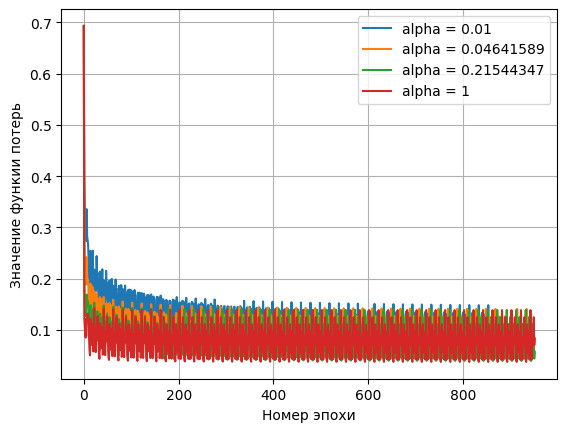

In [12]:
y = results[0]["func"]
x = np.arange(len(results[0]["func"]))
plt.plot(x,y, label="alpha = 0.01")

y = results[1]["func"]
x = np.arange(len(results[1]["func"]))
plt.plot(x,y, label="alpha = 0.04641589")

y = results[2]["func"]
x = np.arange(len(results[2]["func"]))
plt.plot(x,y, label="alpha = 0.21544347")

y = results[3]["func"]
x = np.arange(len(results[3]["func"]))
plt.plot(x,y, label="alpha = 1")

# y = results[4]["func"]
# x = np.arange(len(results[4]["func"]))
# plt.plot(x,y, label="alpha = 0.13894955")

# y = results[5]["func"]
# x = np.arange(len(results[5]["func"]))
# plt.plot(x,y, label="alpha = 0.26826958")

# y = results[6]["func"]
# x = np.arange(len(results[6]["func"]))
# plt.plot(x,y, label="alpha = 0.51794747")

# y = results[7]["func"]
# x = np.arange(len(results[7]["func"]))
# plt.plot(x,y, label="alpha = 1")


plt.legend()
plt.grid()
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функии потерь")

# 7

In [16]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Загрузка ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess2(text):

    # Токенизация
    words = nltk.word_tokenize(text)

    # Удаляем стоп-слова
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Объединяем слова обратно в строку
    preprocessed_text = ' '.join(words)

    return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
texts = [preprocess2(text) for text in preprocessed]

In [27]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.85)
tfidf_data = vectorizer.fit_transform(texts)